In [1]:
gethostname()

"r35c4t4n4"

# Exercise: Parallel Monte Carlo

Calculate the value of $\pi$ through parallel direct Monte Carlo.

A unit circle is inscribed inside a unit square with side length 2 (from -1 to 1). The area of the circle is $\pi$, the area of the square is 4, and the ratio is $\pi/4$. This means that, if you throw $N$ darts randomly at the square, approximately $M=N\pi/4$ of those darts will land inside the unit circle.

Throw darts randomly at a unit square and count how many of them ($M$) landed inside of a unit circle. Approximate $\pi \approx 4M/N$. Visualization:

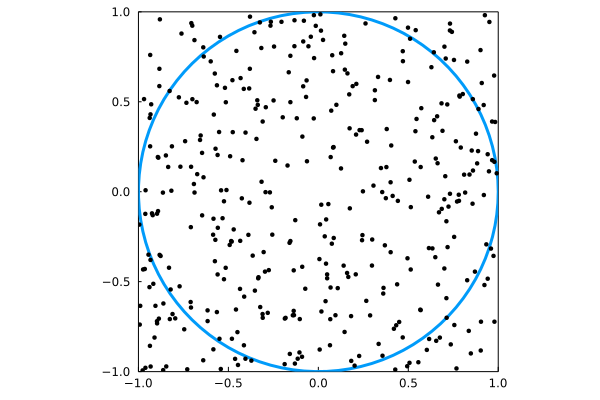

In [2]:
ENV["GKS_ENCODING"]="utf-8"
using Plots, Distributions

# plot circle
circlepts = Plots.partialcircle(0, 2π, 100)
plot(circlepts, aspect_ratio=:equal, xlims=(-1,1), ylims=(-1,1), legend=false, lw=3, grid=false, frame=:box)

# plot darts
N = 400
d = Uniform(-1, 1)
scatter!(rand(d, N), rand(d, N), ms=2.5, color=:black)

### Basic Julia Implementation

In [3]:
function compute_pi(N)
    M = 0 # number of darts that landed in the circle
    for i in 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end
    return 4 * M / N
end

compute_pi (generic function with 1 method)

In [4]:
compute_pi(10_000_000)

3.1420224

### Tasks

1. Based on `compute_pi`, write a function `compute_pi_parallel(N::Int, nworkers::Int)` which does the same but divides the work among `nworkers`-many processes.

2. Benchmark and compare the serial and parallel variants.

3. Write a function `compute_pi_multiple(Ns::Vector{Int})` which computes $\pi$ for all given $N$ values. The function should be serial and based on the given `compute_pi`.

4. Write a function `compute_pi_multiple_parallel(Ns::Vector{Int})` which does the same as in 3) but in parallel. The function should also be based on `compute_pi`.

5. Benchmark and compare the methods from 3) and 4).

6. Calculate $\pi$ estimates for `Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))`. Plot $\pi$ vs $N$ on a semi-log plot (i.e. provide `xscale=:log10` as a keyword argument to `plot`).

A reasonable value could be `N = 10_000_000`.

In [5]:
using Distributed
using BenchmarkTools
using LinearAlgebra

In [6]:
# 1) + 2)
nworkers() == 1 ? addprocs(6) : nothing; # check if we have workers, if not add 6 of them

@everywhere using LinearAlgebra

@everywhere function compute_pi(N::Int)
    M = 0 # number of darts that landed in the circle
    for i = 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end

    return 4*M / N  
end

function compute_pi_parallel(N::Int, nworkers::Int)
    # distribute the dart throwing across ncores
    sum_of_pis = @distributed (+) for i=1:nworkers
        compute_pi(ceil(Int, N / nworkers))
    end

    return sum_of_pis / nworkers  # average value
end

@btime compute_pi_parallel(10_000_000, nworkers())

  8.247 ms (421 allocations: 19.17 KiB)


3.1417321716535658

In [7]:
# 2)
@btime compute_pi(10_000_000)

  48.397 ms (0 allocations: 0 bytes)


3.1412524

In [8]:
# 3) + 5)
function compute_pi_multiple(Ns::Vector{Int})
    pis = zeros(length(Ns))

    for i = 1:length(Ns)
        pis[i] = compute_pi(Ns[i])
    end

    return pis
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple(some_Ns)

  48.399 ms (1 allocation: 96 bytes)


4-element Vector{Float64}:
 3.140116
 3.13998
 3.142052
 3.14106

In [9]:
# 4) + 5)
nworkers() == 1 ? addprocs(6) : nothing;

@everywhere using LinearAlgebra

@everywhere function compute_pi(N::Int)
    M = 0 # number of darts that landed in the circle
    for i = 1:N
        if sqrt(rand()^2 + rand()^2) < 1.0
            M += 1
        end
    end

    return 4*M / N  
end

function compute_pi_multiple_parallel(Ns::Vector{Int})
    pmap(compute_pi, Ns)
end

some_Ns = [1_000_000, 2_000_000, 3_000_000, 4_000_000]

@btime compute_pi_multiple_parallel($some_Ns)

  19.519 ms (256 allocations: 10.69 KiB)


4-element Vector{Float64}:
 3.141596
 3.142556
 3.1400906666666666
 3.141863

  0.564126 seconds (2.37 k allocations: 83.750 KiB)


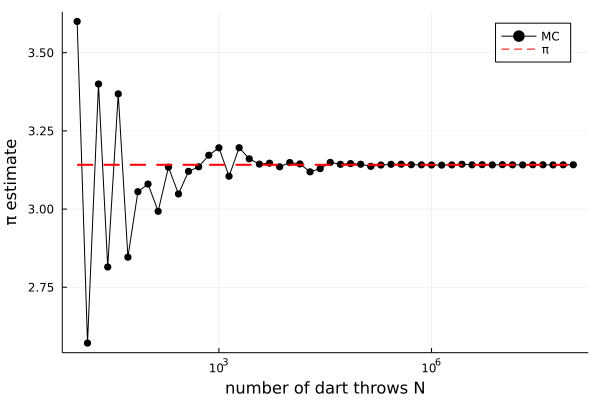

In [10]:
# 6)
Ns = ceil.(Int, exp10.(range(1, stop=8, length=50)))
@time pis = compute_pi_multiple_parallel(Ns)

plot(Ns, pis, color=:black, marker=:circle, lw=1, label="MC", xscale=:log10)
plot!(x->π, label="π", xscale=:log10, linestyle=:dash, color=:red, lw=2)
ylabel!("π estimate")
xlabel!("number of dart throws N")